In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_excel('LKOH.xlsx')
data
# data['<CLOSE>'] = data['<CLOSE>'].astype('float64')

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,LKOH,D,20000201,0,319.0,328.50,311.1,315.00,70539
1,LKOH,D,20000202,0,325.0,325.50,304.0,317.50,122331
2,LKOH,D,20000203,0,320.0,329.49,317.0,326.00,57125
3,LKOH,D,20000204,0,335.0,337.00,330.0,332.89,85244
4,LKOH,D,20000207,0,337.0,342.00,326.0,329.00,47852
...,...,...,...,...,...,...,...,...,...
5997,LKOH,D,20240205,0,7096.5,7185.00,7094.0,7137.50,535071
5998,LKOH,D,20240206,0,7145.0,7171.00,7115.0,7163.00,341917
5999,LKOH,D,20240207,0,7170.0,7272.50,7160.5,7265.00,780871
6000,LKOH,D,20240208,0,7270.5,7288.00,7191.0,7231.50,640712


In [3]:
data['SMAS']=data['<CLOSE>'].rolling(13).mean()
data['SMAL']=data['<CLOSE>'].rolling(92).mean()
data['SMAS']


0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
5997    6939.153846
5998    6962.653846
5999    6995.769231
6000    7025.884615
6001    7059.653846
Name: SMAS, Length: 6002, dtype: float64

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def calc_long(l, r, smas, smal):
    points_long = []
    values_long = []
    for i in range(l, r):
        if smas[i] < smal[i] and smas[i + 1] > smal[i + 1]:
            points_long.append(i + 1)
            values_long.append(data['SMAS'][i + 1])
    return points_long, values_long

def calc_short(l, r, smas, smal):
    points_short = []
    values_short = []
    for i in range(l, r):
        if smas[i] > smal[i] and smas[i + 1] < smal[i + 1]:
            points_short.append(i + 1)
            values_short.append(data['SMAS'][i + 1])
    return points_short, values_short

data_count = 1000
points_long, values_long = calc_long(0, data_count, data['SMAS'], data['SMAL'])
points_short, values_short = calc_short(0, data_count, data['SMAS'], data['SMAL'])
print(points_long)
print(values_long)
print(points_short)
print(values_short)

[132, 179, 307, 441, 674, 806, 884]
[397.59153846153845, 400.05384615384617, 281.22076923076924, 314.84076923076924, 507.47, 472.59000000000003, 541.8061538461538]
[98, 165, 182, 368, 619, 721, 883]
[386.4661538461538, 397.24461538461543, 399.8276923076923, 322.1592307692308, 506.82153846153847, 506.4207692307692, 539.8907692307693]


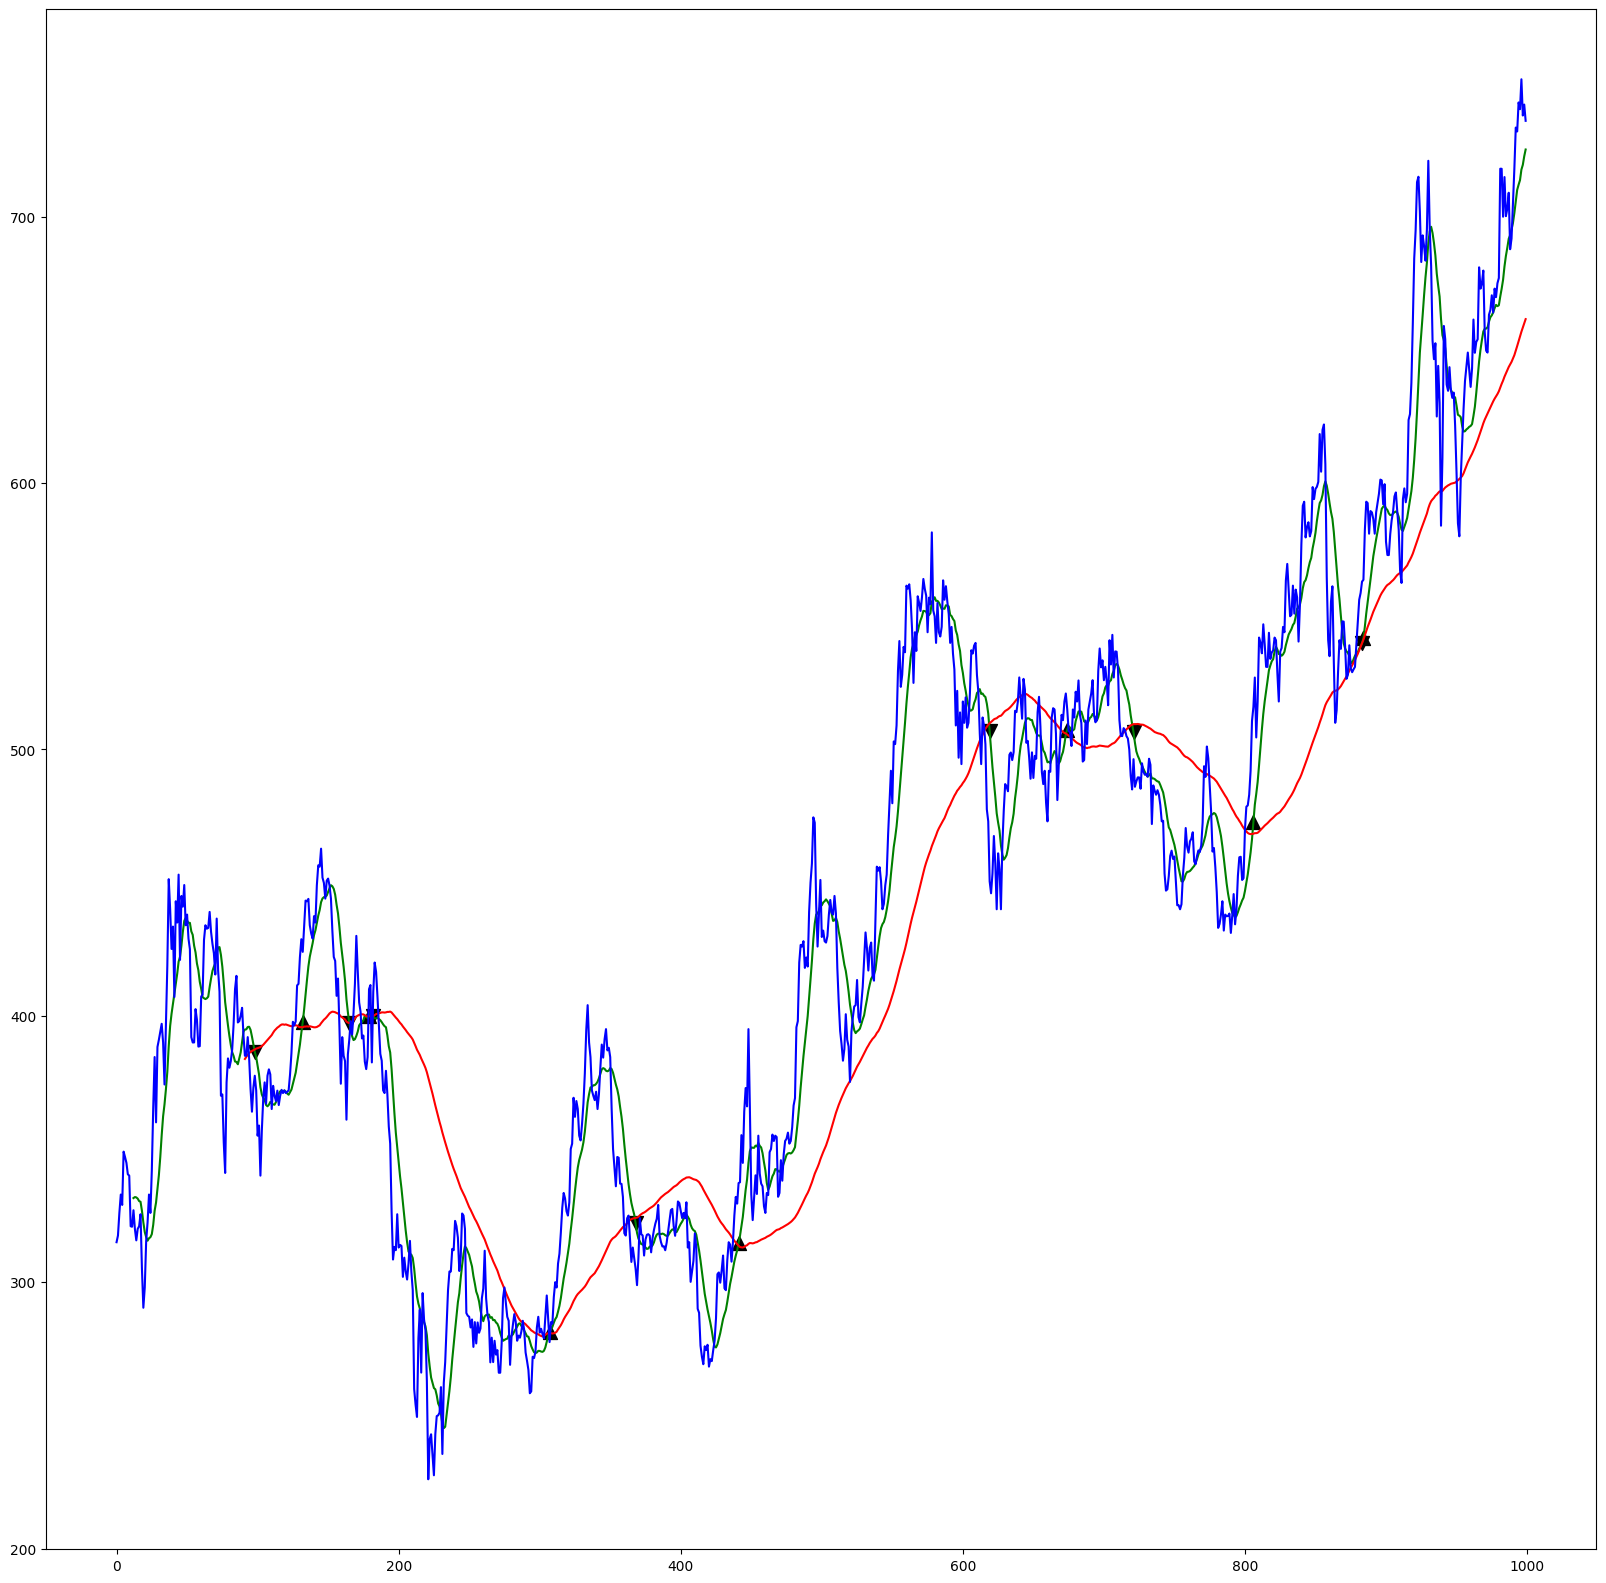

In [6]:
x = np.arange(0, data_count, 1)

plt.figure(figsize=(20,20))
plt.plot(x, data['SMAS'][0:data_count], color='green')
plt.plot(x, data['SMAL'][0:data_count], color='red')
plt.plot(x, data['<CLOSE>'][0:data_count], color='blue')
# plt.plot(200, 350, marker='v', color="white") 
plt.scatter(points_long, values_long, marker='^', color="black", s=100)
plt.scatter(points_short, values_short, marker='v', color="black", s=100)
plt.show()

In [26]:
# for short_period in range(1, 24):
#     for long_period in range(50, 100):
import functools

train_data_count = data.shape[0] // 2
values_per_bar = {}
for bar in range(5, 25, 5):
    values_per_bar[bar] = []

for short_period in range(1, 24):
    for long_period in range(50, 100):
        smas=data['<CLOSE>'].rolling(short_period).mean()
        smal=data['<CLOSE>'].rolling(long_period).mean()
        points_long, values_long = calc_long(0, train_data_count, smas, smal)
        points_short, values_short = calc_short(0, train_data_count, smas, smal)

        for bar in range(5, 25, 5):
            good_count=0
            count=0
            for x in points_long:
                cur_value = data['<CLOSE>'][x]
                next_value = data['<CLOSE>'][x + bar]
                count = count + 1
                if next_value >= cur_value:
                    good_count = good_count + 1
            for x in points_short:
                cur_value = data['<CLOSE>'][x]
                next_value = data['<CLOSE>'][x + bar]
                count = count + 1
                if next_value <= cur_value:
                    good_count = good_count + 1
            ratio = good_count / count
            values_per_bar[bar].append([ratio, short_period, long_period])


def comp1(item0, item1):
    if item0[0] < item1[0]:
        return 1
    if item0[0] > item1[0]:
        return -1
    return 0


sums = np.zeros((100, 100),)

for bar in range(5, 25, 5):
    values_per_bar[bar].sort(key=functools.cmp_to_key(comp1))
    print("bar: {}".format(bar))
    for i in range(0, 10):
        print("short = {}, long = {}, ratio = {}".format(values_per_bar[bar][i][1], values_per_bar[bar][i][2], values_per_bar[bar][i][0]))
    
    for i in range(0, len(values_per_bar[bar])):
        sums[values_per_bar[bar][i][1]][values_per_bar[bar][i][2]] = sums[values_per_bar[bar][i][1]][values_per_bar[bar][i][2]] + (i + 1)



bar: 5
short = 13, long = 92, ratio = 0.75
short = 13, long = 93, ratio = 0.7272727272727273
short = 13, long = 90, ratio = 0.717391304347826
short = 13, long = 91, ratio = 0.7083333333333334
short = 13, long = 94, ratio = 0.7045454545454546
short = 12, long = 96, ratio = 0.6956521739130435
short = 12, long = 99, ratio = 0.6956521739130435
short = 14, long = 94, ratio = 0.6904761904761905
short = 11, long = 89, ratio = 0.6875
short = 13, long = 95, ratio = 0.6818181818181818
bar: 10
short = 16, long = 63, ratio = 0.6833333333333333
short = 16, long = 64, ratio = 0.6833333333333333
short = 13, long = 74, ratio = 0.6538461538461539
short = 17, long = 56, ratio = 0.6451612903225806
short = 10, long = 78, ratio = 0.6379310344827587
short = 11, long = 77, ratio = 0.6379310344827587
short = 11, long = 81, ratio = 0.6379310344827587
short = 15, long = 65, ratio = 0.6363636363636364
short = 11, long = 87, ratio = 0.6346153846153846
short = 13, long = 72, ratio = 0.6333333333333333
bar: 15
shor

In [29]:
good_at_all = []

for i in range (0, 100):
    for j in range(0, 100):
        if sums[i][j] != 0:
            good_at_all.append([i, j, sums[i][j]])

def comp2(item0, item1):
    if item0[2] < item1[2]:
        return -1
    if item0[2] > item1[2]:
        return 1
    return 0

good_at_all.sort(key=functools.cmp_to_key(comp2))

for i in range(0, len(good_at_all)):
    print("short = {}, long = {} , sum = {}".format(good_at_all[i][0], good_at_all[i][1], good_at_all[i][2]))

short = 11, long = 89 , sum = 121.0
short = 11, long = 90 , sum = 148.0
short = 10, long = 92 , sum = 213.0
short = 11, long = 77 , sum = 280.0
short = 10, long = 93 , sum = 295.0
short = 11, long = 91 , sum = 303.0
short = 14, long = 77 , sum = 323.0
short = 12, long = 99 , sum = 376.0
short = 10, long = 91 , sum = 397.0
short = 11, long = 78 , sum = 413.0
short = 11, long = 92 , sum = 434.0
short = 11, long = 93 , sum = 438.0
short = 10, long = 94 , sum = 443.0
short = 11, long = 88 , sum = 460.0
short = 11, long = 79 , sum = 490.0
short = 9, long = 97 , sum = 522.0
short = 14, long = 75 , sum = 565.0
short = 11, long = 80 , sum = 575.0
short = 7, long = 85 , sum = 584.0
short = 14, long = 80 , sum = 584.0
short = 9, long = 94 , sum = 592.0
short = 23, long = 58 , sum = 594.0
short = 21, long = 64 , sum = 595.0
short = 17, long = 57 , sum = 603.0
short = 11, long = 76 , sum = 610.0
short = 12, long = 97 , sum = 610.0
short = 10, long = 53 , sum = 612.0
short = 11, long = 95 , sum = 6

In [34]:
values = []

for short_period in range(1, 24):
    for long_period in range(50, 100):
        smas=data['<CLOSE>'].rolling(short_period).mean()
        smal=data['<CLOSE>'].rolling(long_period).mean()
        points_long, values_long = calc_long(0, train_data_count, smas, smal)
        points_short, values_short = calc_short(0, train_data_count, smas, smal)
        deposit = 100000
        start_deposit = deposit
        points = points_short
        points.extend(points_long)
        points.sort()
        if (points_short[0] < points_long[0]):
            for i in range(0, len(points) - 1) :
                curx = points[i]
                nextx = points[i + 1]
                cnt = int((deposit) / data['<CLOSE>'][curx])
                if i % 2 == 0:
                    deposit = deposit + (data['<CLOSE>'][curx] - data['<CLOSE>'][nextx]) * cnt
                else:
                    deposit = deposit + (-data['<CLOSE>'][curx] + data['<CLOSE>'][nextx]) * cnt
        else:
            for i in range(0, len(points) - 1) :
                curx = points[i]
                nextx = points[i + 1]
                cnt = int((deposit) / data['<CLOSE>'][curx])
                if i % 2 == 0:
                    deposit = deposit + (data['<CLOSE>'][curx] - data['<CLOSE>'][nextx]) * cnt
                else:
                    deposit = deposit + (-data['<CLOSE>'][curx] + data['<CLOSE>'][nextx]) * cnt
        
        value = deposit / start_deposit
        values.append([short_period, long_period, value])
    
def comp3(item0, item1):
    if item0[2] > item1[2]:
        return -1
    if item0[2] < item1[2]:
        return 1
    return 0

values.sort(key=functools.cmp_to_key(comp3))
for i in range(0, 10):
    print("short = {}, long = {}, value = {}".format(values[i][0], values[i][1], values[i][2]))


short = 9, long = 50, value = 3.5734266999999993
short = 7, long = 50, value = 3.3402058000000037
short = 8, long = 51, value = 3.0765358000000003
short = 8, long = 50, value = 2.7645370999999996
short = 9, long = 51, value = 2.544266700000001
short = 7, long = 52, value = 2.5163601000000013
short = 12, long = 74, value = 2.4128788000000023
short = 7, long = 51, value = 2.4019639000000015
short = 11, long = 89, value = 2.383585199999999
short = 20, long = 64, value = 2.3761430000000026


In [ ]:
periods = [[11, 89], [11, 90], [10, 92], [9, 50], [7, 50], [8, 51]]

points_long, values_long = calc_long(train_data_count, data.shape[0], smas, smal)
points_short, values_short = calc_short(train_data_count, data.shape[0], smas, smal)